In [1]:
import sys
from glob import glob
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy import signal
from scipy.stats import pearsonr
from astropy.table import Table
import pandas as pd
from astropy.table import unique, join
from sklearn.preprocessing import minmax_scale
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import scale

In [2]:
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols
from lightcurve import LightCurve

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
tab_uvot = read_uvotsource(f'../download_scripts/NGC1313/X-2_src_uvotsource_all.fits')

Reading uvotsource...
Reading file ../download_scripts/NGC1313/X-2_src_uvotsource_all.fits
tab len=538 unique_obs=485
UVOT flag summary:
FLAG_AB_MAG_99      = 15 / 538 (2.79%)
FLAG_UPPER_LIM      = 23 / 538 (4.28%)
FLAG_AB_MAG_ERR>2   = 15 / 538 (2.79%)
FLAG_AB_MAG_>10_<30 = 15 / 538 (2.79%)


Loading XRT...
simbad_name=NAME_NGC_1313_X-2 curve=HARD pandas=False
Loading file: /mnt/d/anticorr_data/UKSSDC/NAME_NGC_1313_X-2/USERPROD_45605/lc/hardrat_HARD_PC.csv
df shape=(452, 6) unique_obs=452
XRT FLAG SUMMARY
FLAG_RATE=0 = 1 / 452 (0.22%)
Reading uvotsource...
Reading file ../download_scripts/NGC1313/X-2_src_uvotsource_all.fits
tab len=538 unique_obs=485
UVOT flag summary:
FLAG_AB_MAG_99      = 15 / 538 (2.79%)
FLAG_UPPER_LIM      = 23 / 538 (4.28%)
FLAG_AB_MAG_ERR>2   = 15 / 538 (2.79%)
FLAG_AB_MAG_>10_<30 = 15 / 538 (2.79%)


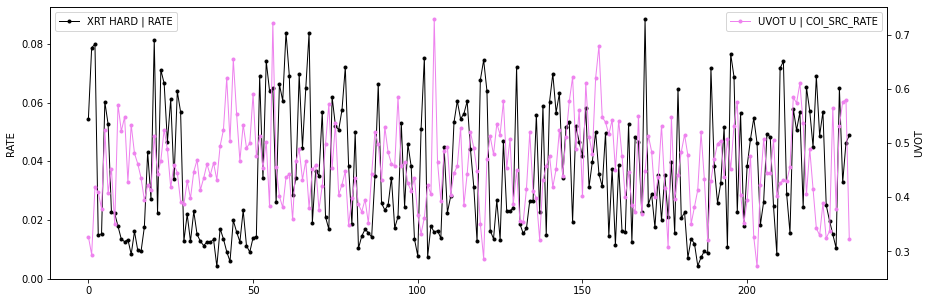

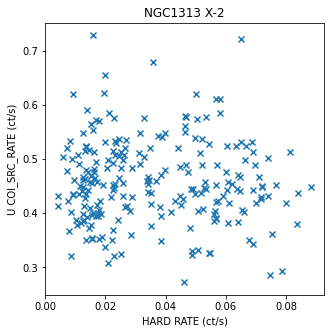

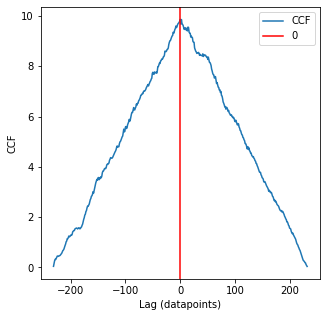

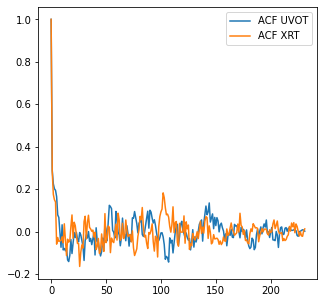

In [4]:
# Parameters
plot_errors = False
simbad_name = 'NAME_NGC_1313_X-2'
local_name  = source_names_dict[simbad_name]
readable_name = source_names_readable[simbad_name]

uvot_filter   = 'U'
xrt_curve     = 'HARD'

xrt_rate      = 'RATE'
xrt_rate_err  = 'RATE_ERR'

uvot_rate     = 'COI_SRC_RATE'
uvot_rate_err = 'COI_SRC_RATE_ERR'

# Load X-ray Data
tab_xrt_full = load_xrt(simbad_name=simbad_name, curve=xrt_curve, pandas=False)

# Load UV Data
tab_uvot = read_uvotsource(f'../download_scripts/{local_name}/X-2_src_uvotsource_all.fits')
tab_uvot = tab_uvot[tab_uvot['FILTER'] == uvot_filter]
tab_uvot = unique(tab_uvot, keys='OBSID')
tab_uvot = tab_uvot[tab_uvot[uvot_rate] < 3]

# Join Data
tab_join = join(tab_uvot, tab_xrt_full , join_type='inner', keys='OBSID')

# Get x,y data
t = tab_join['MJD_2']

x = tab_join[xrt_rate]
x_err = tab_join[xrt_rate_err]

y = tab_join[uvot_rate]
y_err = tab_join[uvot_rate_err]

#y_err = (abs(tab_join['RATE_ERR_NEG']), tab_join['RATE_ERR_POS'])
#y_err = tab_join['RATE_ERR_POS'] - tab_join['RATE_ERR_NEG']


# Plot lightcurve
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax2 = ax.twinx()
ax.plot(range(len(x)), x, lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate}', ls='-', marker='.', color='black')
ax2.plot(range(len(y)), y, lw=1.0, label=f'UVOT {uvot_filter} | {uvot_rate}', ls='-', marker='.', color='violet')
ax.set_ylabel(f'{xrt_rate} ')
ax2.set_ylabel('UVOT')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot correlation
plt.figure(figsize=(5,5))
if plot_errors:
    plt.errorbar(x, y, xerr=x_err, yerr=y_err,  lw=1.0, capsize=1.0, ls='none')
else:
    plt.scatter(x, y, marker='x')
plt.title(readable_name)
plt.xlabel(f'{xrt_curve} {xrt_rate} (ct/s)')
plt.ylabel(f'{uvot_filter} {uvot_rate} (ct/s)')

# Plot CCF
lags = np.arange(-len(x) + 1, len(x))
c = signal.correlate(x / np.std(x), y / np.std(y), 'full') 
c = c / len(x)
r, p_val = pearsonr(x,y)
lag_max = lags[np.argmax(c)]

plt.figure(figsize=(5,5))
plt.plot(lags, c, label='CCF')
plt.axvline(lag_max, color='red', label=f'{lag_max}')
plt.legend()
plt.xlabel('Lag (datapoints)')
plt.ylabel('CCF')
plt.show()

#calculate autocorrelations
import statsmodels.api as sm
acf_y = sm.tsa.acf(y, nlags=2*len(y))
acf_x = sm.tsa.acf(x, nlags=2*len(x))

plt.figure(figsize=(5,5))
plt.plot(acf_x, label=f'ACF UVOT')
plt.plot(acf_y, label=f'ACF XRT')

plt.legend()

In [5]:
tab_join

MET,EXTNAME,TSTART,TSTOP,EXPOSURE,TELAPSE,TIME,SRC_AREA,BKG_AREA,STD_AREA,PLATE_SCALE,RAW_TOT_CNTS,RAW_TOT_CNTS_ERR,RAW_BKG_CNTS,RAW_BKG_CNTS_ERR,RAW_STD_CNTS,RAW_STD_CNTS_ERR,RAW_TOT_RATE,RAW_TOT_RATE_ERR,RAW_BKG_RATE,RAW_BKG_RATE_ERR,RAW_STD_RATE,RAW_STD_RATE_ERR,COI_STD_FACTOR,COI_STD_FACTOR_ERR,COI_BKG_FACTOR,COI_BKG_FACTOR_ERR,COI_TOT_RATE,COI_TOT_RATE_ERR,COI_BKG_RATE,COI_BKG_RATE_ERR,COI_SRC_RATE,COI_SRC_RATE_ERR,AP_FACTOR,AP_FACTOR_ERR,AP_COI_SRC_RATE,AP_COI_SRC_RATE_ERR,LSS_FACTOR,LSS_RATE,LSS_RATE_ERR,SENSCORR_FACTOR,SENSCORR_RATE,SENSCORR_RATE_ERR,CORR_RATE,CORR_RATE_ERR,AB_MAG,AB_MAG_ERR,AB_MAG_ERR_STAT,AB_MAG_ERR_SYS,AB_MAG_BKG,AB_MAG_BKG_ERR_STAT,AB_MAG_BKG_ERR_SYS,AB_MAG_BKG_ERR,AB_MAG_LIM,AB_MAG_LIM_SIG,AB_MAG_COI_LIM,AB_FLUX_AA,AB_FLUX_AA_ERR_STAT,AB_FLUX_AA_ERR_SYS,AB_FLUX_AA_ERR,AB_FLUX_AA_BKG,AB_FLUX_AA_BKG_ERR_STAT,AB_FLUX_AA_BKG_ERR_SYS,AB_FLUX_AA_BKG_ERR,AB_FLUX_AA_LIM,AB_FLUX_AA_COI_LIM,AB_FLUX_HZ,AB_FLUX_HZ_ERR_STAT,AB_FLUX_HZ_ERR_SYS,AB_FLUX_HZ_ERR,AB_FLUX_HZ_BKG,AB_FLUX_HZ_BKG_ERR_STAT,AB_FLUX_HZ_BKG_ERR_SYS,AB_FLUX_HZ_BKG_ERR,AB_FLUX_HZ_LIM,AB_FLUX_HZ_COI_LIM,MAG,MAG_ERR,MAG_ERR_STAT,MAG_ERR_SYS,MAG_BKG,MAG_BKG_ERR_STAT,MAG_BKG_ERR_SYS,MAG_BKG_ERR,MAG_LIM,MAG_LIM_SIG,MAG_COI_LIM,FLUX_AA,FLUX_AA_ERR_STAT,FLUX_AA_ERR_SYS,FLUX_AA_ERR,FLUX_AA_BKG,FLUX_AA_BKG_ERR_STAT,FLUX_AA_BKG_ERR_SYS,FLUX_AA_BKG_ERR,FLUX_AA_LIM,FLUX_AA_COI_LIM,FLUX_HZ,FLUX_HZ_ERR_STAT,FLUX_HZ_ERR_SYS,FLUX_HZ_ERR,FLUX_HZ_BKG,FLUX_HZ_BKG_ERR_STAT,FLUX_HZ_BKG_ERR_SYS,FLUX_HZ_BKG_ERR,FLUX_HZ_LIM,FLUX_HZ_COI_LIM,COI_RATE_LIMIT,CORR_RATE_LIMIT,FILTER,RA,DEC,DETX,DETY,NSIGMA,FRAMTIME,SATURATED,SYS_ERR,SRCEXP,BKGEXP,OBSID,MJD_1,YEAR,MJD_0_1,FLAG_AB_MAG_99,FLAG_UPPER_LIM,FLAG_AB_MAG_ERR>2,FLAG_AB_MAG_>10_<30,MJD_2,MJD_ERR_POS,MJD_ERR_NEG,RATE,RATE_ERR,MJD_0_2,FLAG_RATE=0
s,,s,s,s,s,s,arcsec2,arcsec2,arcsec2,arcsec / pix,ct,ct,ct,ct,ct,ct,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,,,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,ct / s,ct / s,,ct / s,ct / s,,ct / s,ct / s,ct / s,ct / s,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,ct / s,ct / s,,deg,deg,pix,pix,,s,,,s,s,,s,,s,,,,,,,,,,,
float64,bytes12,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float64,float64,float32,float32,float32,float32,int16,bool,float32,float32,str11,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,bool
272515598.4688,U,272515095.31244,272516101.62516,990.44116,1006.31274,0.0,78.67262,706.96594,78.67262,1.004,2139.878,45.71299,16386.896,126.7034